<a href="https://colab.research.google.com/github/SherriSc/UTAustinAIMLPython/blob/main/CV_Project_Full_Code_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [ ]:
# Installing the libraries with the specified version.
# uncomment and run the following line if Google Colab is being used

!pip install tensorflow scikit-learn seaborn matplotlib numpy pandas opencv-python -q --user

In [ ]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2 # this is an important module to get imported which may even cause issues while reading the data if not used
import seaborn as sns # for data visualization
import random

# Tensorflow modules
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential # for sequential model
from tensorflow.keras.layers import Dense, Dropout, Flatten # importing the different layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical # to perform one-hot encoding
from tensorflow.keras.optimizers import Adam, SGD # to optimize the model
from tensorflow.keras.callbacks import EarlyStopping  # regularization method to prevent overfitting
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import losses, optimizers
from tensorflow.keras.preprocessing import image

# Sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelBinarizer

# Display images using OpenCV
from google.colab.patches import cv2_imshow

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading images from the .npy file, which will load as a tuple
images_tuple = np.load('/content/drive/MyDrive/images.npy')

# Converting the images into a numpy array
images = np.array(images_tuple)

In [ ]:
# Loading labels from the .csv file
labels = pd.read_csv('/content/drive/MyDrive/Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [ ]:
# Printing the shape of the images and the labels
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


So this means that we have 4,750 images. The images are 128x128 pixels, and with 3 color channels (which means the data is RGB or BGR -- color pictures rather than grayscale or black and white).

And checking the labels, we have the same # of labels as pictures (4,750), which is good! We have 1 column that contains the labels themselves.

In [ ]:
# Getting the unique categories from the labels
label_names = labels['Label'].unique()

# Printing the label names
print(label_names)

['Small-flowered Cranesbill' 'Fat Hen' 'Shepherds Purse' 'Common wheat'
 'Common Chickweed' 'Charlock' 'Cleavers' 'Scentless Mayweed' 'Sugar beet'
 'Maize' 'Black-grass' 'Loose Silky-bent']


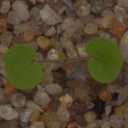

In [ ]:
# I want to see what I'm dealing with, so I'll look at the first image with OpenCV
cv2_imshow(images[0])

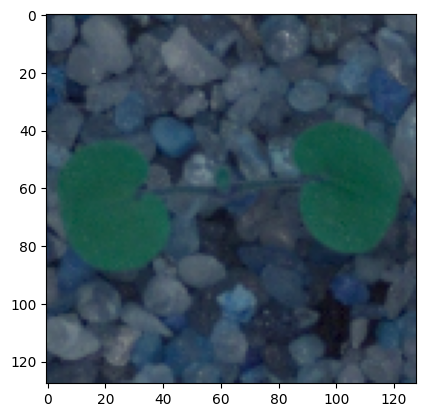

In [ ]:
# Now I want to see the image using matplotlib
plt.imshow(images[0])

In [ ]:
# Okay it definitely looks like these are in BGR; I'll conver them to RGB
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

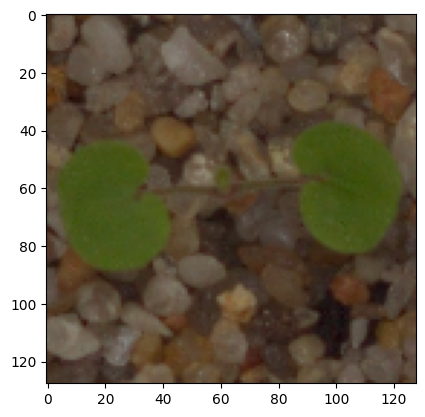

In [ ]:
# Okay let's look at the same image in matplotlib again
plt.imshow(images[0])

That's better! Our images are now in RGB.

In [ ]:
# Now I have no idea what kind of plant this is, so I'll look at the data label.
labels.iloc[0]

Label    Small-flowered Cranesbill
Name: 0, dtype: object

Okay, the first picture is apparently a Small-flowered Cranesbill. Hopefully I can create a good model to identify these plants because I have no idea what these are! :-)

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

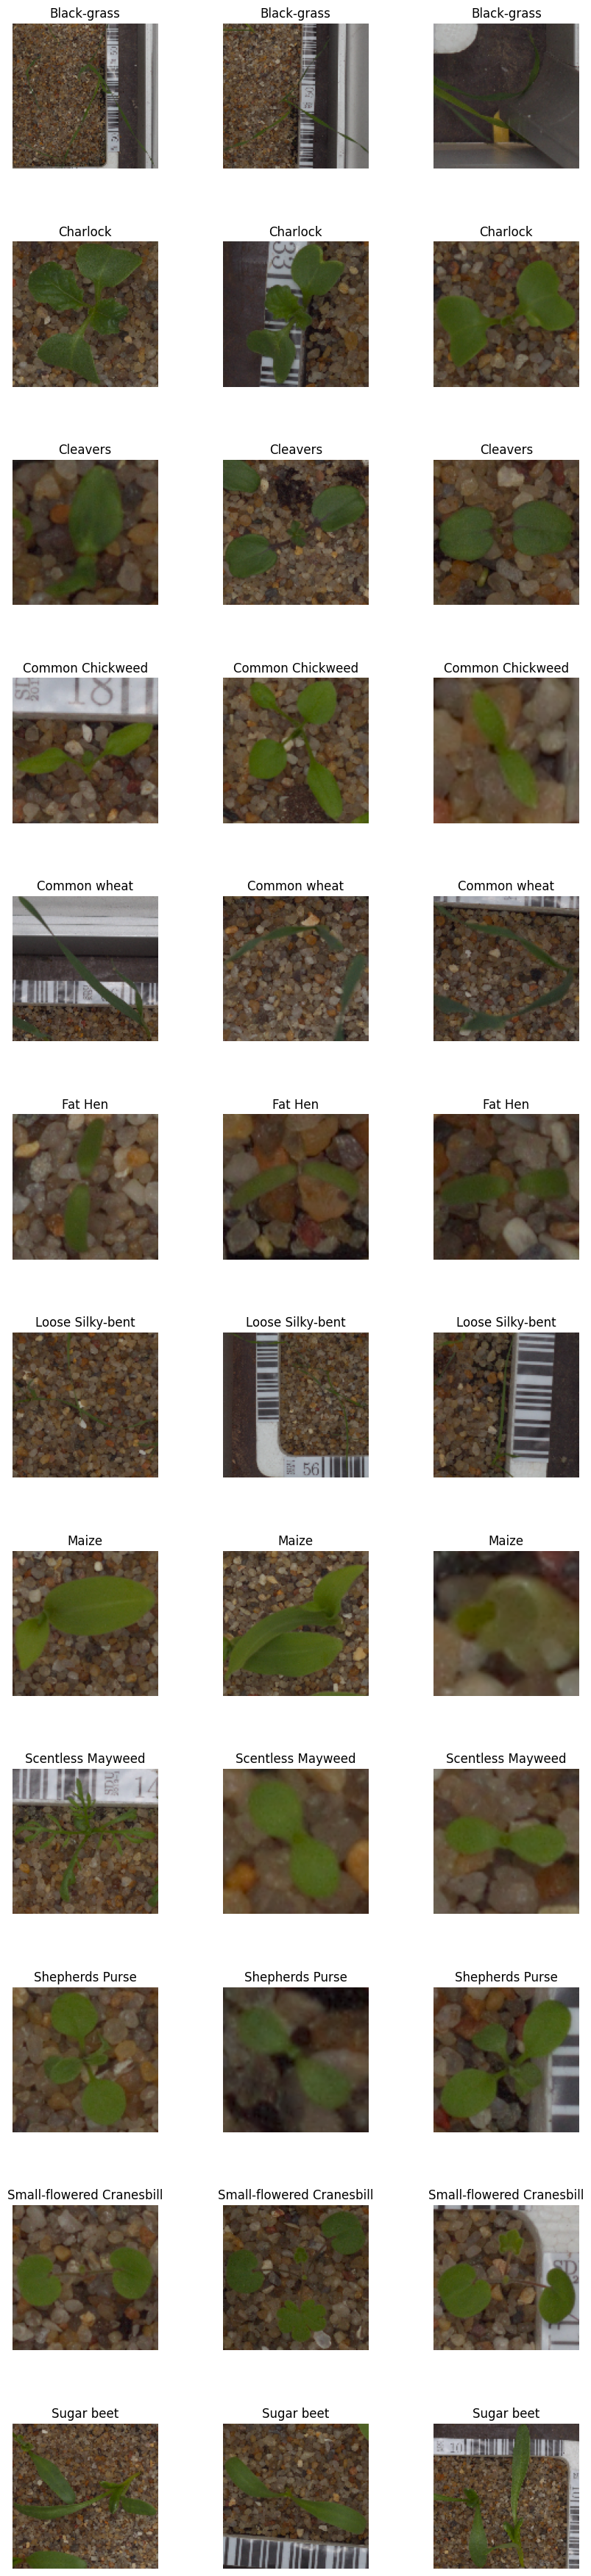

In [ ]:
num_samples = 3  # Number of samples per category
categories = np.unique(labels['Label'])  # Getting the unique categories
fig, axes = plt.subplots(len(categories), num_samples, figsize=(num_samples * 3, len(categories) * 3))
fig.tight_layout(pad=3.0)

for i, category in enumerate(categories):
    # Get the indices of images with the current label
    label_indices = labels[labels['Label'] == category].index

    for j in range(num_samples):
        if j < len(label_indices):
            # Get the image index
            img_index = label_indices[j]
            # Plot the image
            axes[i, j].imshow(images[img_index])
            axes[i, j].axis('off')
            axes[i, j].set_title(category)
        else:
            axes[i, j].axis('off')

plt.show()


1. How are these different category plant images different from each other?

Some of the plants are grasses without any recognizable leaves (like the wheat and grass). Others are plants with one or more leaves of different shapes and sizes. The scales of the plant photos are different, seemingly because some of the plants are smaller.

All of the plants have gravel backgrounds, and some also include pictures of rulers or other backgrounds.

2. Is the dataset provided an imbalance? (Check with using bar plots)

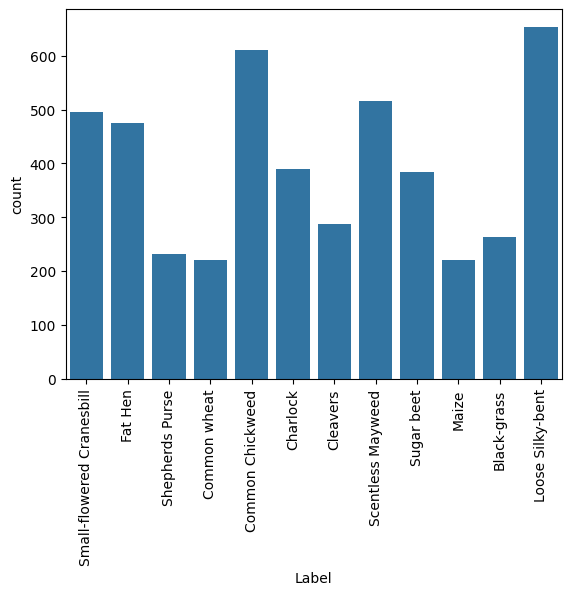

In [ ]:
# Checking whether the data is imbalanced
count_plot = sns.countplot(x='Label', data=labels)
plt.xticks(rotation=90) # Rotate x-axis labels using matplotlib.pyplot.xticks()
plt.show()

This is an imbalanced dataset:

*   A couple of labels have over 600 images
*   Four labels have just over 200 images
*   The rest of the labels have between 300 and 400 images, approximately

I'll handle this by assign class weights during model training, and after the train test split, to balance the influence of the higher classes. I will also try augmentation after train test split. And the final thing I'll try will be oversampling using SMOTE.




## Data Pre-Processing

### Convert the BGR images to RGB images.

Hmm. I realize that I was using Matplotlib, above, and I thought it looked okay. But now that I see it with CV2, I think it's probably BGR.

I'm not really sure which is correct still, but I think it's in BGR. Everything looks a little blue in the second picture, and I seem to have lost the red. So I'm going to do the conversion from BGR to RGB.  

I'm doing this because I ultimately want to put the data in grayscale.

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

SHERRI'S NOTE: I'm providing the formula to re-size the images to show that I know it for the assignment. But I actually am going to save them in a dataset I'm not going to use because I don't want to resize my images and make them smaller.

In [ ]:
# Resizing the images
images_decreased = []
height = 64
width = 64
dimensions = (height, width)
for i in range(len(images)):
  images_decreased.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [ ]:
# Perform the train-test split with shuffling and stratification
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images), labels, test_size=0.1, shuffle=True, random_state=42, stratify = labels)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, shuffle=True, random_state=42, stratify = y_temp)

# Printing to make sure that it worked
print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Testing set size:", X_test.shape, y_test.shape)

Training set size: (3847, 128, 128, 3) (3847, 1)
Validation set size: (428, 128, 128, 3) (428, 1)
Testing set size: (475, 128, 128, 3) (475, 1)


### Encode the target labels

In [ ]:
## Instead of one-hot encoding, I'm going to use the LabelBinarizer from sklearn.model.preprocessing, which is better for encoding the target variable in a multi class problem
# Storing the LabelBinarizer function in lb variable
lb = LabelBinarizer()

# Applying fit transform on train target variable
y_train = lb.fit_transform(y_train)

# Applying fit transform on val target variable
y_val = lb.fit_transform(y_val)

# Applying only transform on test target variable
y_test = lb.transform(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3847, 12)
(428, 12)
(475, 12)


### Data Normalization

In [ ]:
# Normalizing the data - I could import sklearn StandardScaler, but instead I'm just going to divide all the values by 255
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print("X_train min:", X_train.min(), "X_train max:", X_train.max())
print("X_val min:", X_val.min(), "X_val max:", X_val.max())
print("X_test min:", X_test.min(), "X_test max:", X_test.max())

X_train min: 0.0 X_train max: 1.0
X_val min: 0.0 X_val max: 1.0
X_test min: 0.0 X_test max: 1.0


## Model Building

### MODEL 1: Convolutional Neural Network (CNN) with SGD Optimizer with learning rate of 0.01 and momentum of 0.9

In [ ]:
# Clearing the backend session
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Initializing a sequential model
model1 = Sequential()

# Adding first conv layer with 128 filters, kernel size 3x3, padding 'same', and relu activation
model1.add(Conv2D(128, (3, 3), activation = 'relu', padding='same', input_shape=(128, 128, 3)))
# Adding max pooling to redue the size of the output of the first conv layer
model1.add(MaxPooling2D(2, 2))

# Adding second conv layer with 64 filters, kernel size 3x3, padding 'same', and relu activation
model1.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
# Adding max pooling
model1.add(MaxPooling2D(2, 2))

# Flattening the output
model1.add(Flatten())

# Adding a dense layer with 128 neurons and relu activation
model1.add(Dense(128, activation = 'relu'))
model1.add(Dropout(0.5))

# Adding the output layer with 12 units and softmax activation
model1.add(Dense(12, activation = 'softmax'))

# Using SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compiling the model
model1.compile( optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the model summary
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,467,660 (32.30 MB)

 Trainable params: 8,467,660 (32.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fitting the model on the train data
history1 = model1.fit(X_train, y_train, epochs = 30, validation_data = (X_val, y_val), batch_size=32, verbose = 2)

Epoch 1/30
121/121 - 10s - 83ms/step - accuracy: 0.1391 - loss: 2.4406 - val_accuracy: 0.1752 - val_loss: 2.3720
Epoch 2/30
121/121 - 1s - 8ms/step - accuracy: 0.2771 - loss: 2.0997 - val_accuracy: 0.3598 - val_loss: 1.9785
Epoch 3/30
121/121 - 1s - 8ms/step - accuracy: 0.3717 - loss: 1.8200 - val_accuracy: 0.4463 - val_loss: 1.5603
Epoch 4/30
121/121 - 1s - 8ms/step - accuracy: 0.4255 - loss: 1.6551 - val_accuracy: 0.4930 - val_loss: 1.4327
Epoch 5/30
121/121 - 1s - 8ms/step - accuracy: 0.4822 - loss: 1.4805 - val_accuracy: 0.5537 - val_loss: 1.3662
Epoch 6/30
121/121 - 1s - 8ms/step - accuracy: 0.5040 - loss: 1.4230 - val_accuracy: 0.5701 - val_loss: 1.3139
Epoch 7/30
121/121 - 1s - 8ms/step - accuracy: 0.5204 - loss: 1.3788 - val_accuracy: 0.4720 - val_loss: 1.4276
Epoch 8/30
121/121 - 1s - 8ms/step - accuracy: 0.5693 - loss: 1.2280 - val_accuracy: 0.6379 - val_loss: 1.0875
Epoch 9/30
121/121 - 1s - 8ms/step - accuracy: 0.5781 - loss: 1.1978 - val_accuracy: 0.6776 - val_loss: 1.0470

Okay that was great! We're at a validation accuracy of 0.7500. To try to get better:
1. I'll decrease the learning rate to 0.001
2. I'll change the optimizer to Adam
3. I'll adjust the batch sizes
4. I'll add more convolulational layers and increase the number of filters
5. I'll add Batch Normalization
6. I'll adjust the dropout rate higher

### MODEL

In [ ]:
### MODEL 2: CNN with Adam Optimizer with learning rate of 0.001, additional layers, additional filters, batch normalization, and incrased drop out rate.

In [ ]:
# Clearing the backend session
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Initializing a sequential model
model2 = Sequential()

# Adding first conv layer with 128 filters, kernel size 3x3, padding 'same', and relu activation
model2.add(Conv2D(128, (3, 3), activation = 'relu', padding='same', input_shape=(128, 128, 3)))

# Adding second conv layer with 64 filters, kernel size 3x3, padding 'same', and relu activation
model2.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
# Adding max pooling
model2.add(MaxPooling2D(2, 2))

# Adding third conv layer with 32 filters, kernel size = 3x3, padding = 'same', and relu activation
model2.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))

# Adding fourth conv layer with 16 filters, kernel size = 3x3, padding = 'same', and relu activation
model2.add(Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
# Adding Batch Normalization
model2.add(BatchNormalization())

# Flattening the output
model2.add(Flatten())

# Adding first dense layer with 128 neurons, relu activation, and 70% dropout
model2.add(Dense(128, activation = 'relu'))
model2.add(Dropout(0.7))

# Adding second dense layer with 64 neurons, relu activation, and 50% dropout
model2.add(Dense(64, activation = 'relu'))
model2.add(Dropout(0.5))

# Adding third dense layer with 32 neurons, relu activation, and 30% dropout
model2.add(Dense(32, activation = 'relu'))
model2.add(Dropout(0.3))

# Adding fourth dense layer with 16 neurons, relu activation, and 10% dropout
model2.add(Dense(16, activation = 'relu'))
model2.add(Dropout(0.1))

# Adding the output layer with 12 units and softmax activation
model2.add(Dense(12, activation = 'softmax'))

# Using Adam Optimizer
opt = Adam(learning_rate=0.001)

# Compiling the model
model2.compile( optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the model summary
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,500,332 (32.43 MB)

 Trainable params: 8,500,300 (32.43 MB)

 Non-trainable params: 32 (128.00 B)

In [ ]:
# Fitting the model on the train data
history2 = model2.fit(X_train, y_train, epochs = 30, validation_data = (X_val, y_val), batch_size=30, verbose = 2)

Epoch 1/30
129/129 - 20s - 152ms/step - accuracy: 0.1076 - loss: 2.4924 - val_accuracy: 0.1285 - val_loss: 2.4500
Epoch 2/30
129/129 - 2s - 12ms/step - accuracy: 0.1256 - loss: 2.4536 - val_accuracy: 0.1379 - val_loss: 2.4352
Epoch 3/30
129/129 - 2s - 12ms/step - accuracy: 0.1240 - loss: 2.4472 - val_accuracy: 0.1285 - val_loss: 2.4392
Epoch 4/30
129/129 - 2s - 12ms/step - accuracy: 0.1295 - loss: 2.4365 - val_accuracy: 0.1285 - val_loss: 2.4333
Epoch 5/30
129/129 - 2s - 12ms/step - accuracy: 0.1193 - loss: 2.4347 - val_accuracy: 0.1379 - val_loss: 2.4265
Epoch 6/30
129/129 - 2s - 12ms/step - accuracy: 0.1300 - loss: 2.4290 - val_accuracy: 0.1285 - val_loss: 2.4254
Epoch 7/30
129/129 - 2s - 12ms/step - accuracy: 0.1302 - loss: 2.4309 - val_accuracy: 0.1379 - val_loss: 2.4200
Epoch 8/30
129/129 - 2s - 13ms/step - accuracy: 0.1362 - loss: 2.4273 - val_accuracy: 0.1285 - val_loss: 2.4223
Epoch 9/30
129/129 - 2s - 12ms/step - accuracy: 0.1271 - loss: 2.4260 - val_accuracy: 0.1379 - val_los

## Model Performance Improvement

### MODEL 3: Exact same model as model 2 but with ReduceLRonPlateau()

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [ ]:
# Clearing the backend session
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Initializing a sequential model
model3 = Sequential()

# Adding first conv layer with 128 filters, kernel size 3x3, padding 'same', and relu activation
model3.add(Conv2D(128, (3, 3), activation = 'relu', padding='same', input_shape=(128, 128, 3)))

# Adding second conv layer with 64 filters, kernel size 3x3, padding 'same', and relu activation
model3.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
# Adding max pooling
model3.add(MaxPooling2D(2, 2))

# Adding third conv layer with 32 filters, kernel size = 3x3, padding = 'same', and relu activation
model3.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))

# Adding fourth conv layer with 16 filters, kernel size = 3x3, padding = 'same', and relu activation
model3.add(Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
# Adding Batch Normalization
model3.add(BatchNormalization())

# Flattening the output
model3.add(Flatten())

# Adding first dense layer with 128 neurons, relu activation, and 70% dropout
model3.add(Dense(128, activation = 'relu'))
model3.add(Dropout(0.7))

# Adding second dense layer with 64 neurons, relu activation, and 50% dropout
model3.add(Dense(64, activation = 'relu'))
model3.add(Dropout(0.5))

# Adding third dense layer with 32 neurons, relu activation, and 30% dropout
model3.add(Dense(32, activation = 'relu'))
model3.add(Dropout(0.3))

# Adding fourth dense layer with 16 neurons, relu activation, and 10% dropout
model3.add(Dense(16, activation = 'relu'))
model3.add(Dropout(0.1))

# Adding the output layer with 12 units and softmax activation
model3.add(Dense(12, activation = 'softmax'))

# Using Adam Optimizer
opt = Adam(learning_rate=0.001)

# Compiling the model
model3.compile( optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the model summary
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,500,332 (32.43 MB)

 Trainable params: 8,500,300 (32.43 MB)

 Non-trainable params: 32 (128.00 B)

In [ ]:
# Import the library
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create the callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Adding the callback to the training model
history3 = model3.fit(X_train, y_train, epochs = 30, validation_data = (X_val, y_val), batch_size=30, verbose = 2, callbacks=[reduce_lr])

Epoch 1/30
129/129 - 12s - 93ms/step - accuracy: 0.1141 - loss: 2.4886 - val_accuracy: 0.1379 - val_loss: 2.4464 - learning_rate: 0.0010
Epoch 2/30
129/129 - 2s - 13ms/step - accuracy: 0.1313 - loss: 2.4529 - val_accuracy: 0.1285 - val_loss: 2.4392 - learning_rate: 0.0010
Epoch 3/30
129/129 - 2s - 12ms/step - accuracy: 0.1230 - loss: 2.4426 - val_accuracy: 0.1285 - val_loss: 2.4328 - learning_rate: 0.0010
Epoch 4/30
129/129 - 2s - 12ms/step - accuracy: 0.1289 - loss: 2.4405 - val_accuracy: 0.1285 - val_loss: 2.4275 - learning_rate: 0.0010
Epoch 5/30
129/129 - 2s - 12ms/step - accuracy: 0.1289 - loss: 2.4304 - val_accuracy: 0.1285 - val_loss: 2.4299 - learning_rate: 0.0010
Epoch 6/30
129/129 - 2s - 12ms/step - accuracy: 0.1297 - loss: 2.4310 - val_accuracy: 0.1285 - val_loss: 2.4267 - learning_rate: 0.0010
Epoch 7/30
129/129 - 2s - 12ms/step - accuracy: 0.1341 - loss: 2.4284 - val_accuracy: 0.1379 - val_loss: 2.4232 - learning_rate: 0.0010
Epoch 8/30
129/129 - 2s - 12ms/step - accuracy:

Okay, this was better than the second model, but still not as good as the first model. Let's try some additional data augmentation.

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

###MODEL 4: Same as 3 but with some data augmentation

In [ ]:
# Clearing the backend session
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Initializing a sequential model
model4 = Sequential()

# Adding first conv layer with 128 filters, kernel size 3x3, padding 'same', and relu activation
model4.add(Conv2D(128, (3, 3), activation = 'relu', padding='same', input_shape=(128, 128, 3)))

# Adding second conv layer with 64 filters, kernel size 3x3, padding 'same', and relu activation
model4.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
# Adding max pooling
model4.add(MaxPooling2D(2, 2))

# Adding third conv layer with 32 filters, kernel size = 3x3, padding = 'same', and relu activation
model4.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))

# Adding fourth conv layer with 16 filters, kernel size = 3x3, padding = 'same', and relu activation
model4.add(Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
# Adding Batch Normalization
model4.add(BatchNormalization())

# Flattening the output
model4.add(Flatten())

# Adding first dense layer with 128 neurons, relu activation, and 70% dropout
model4.add(Dense(128, activation = 'relu'))
model4.add(Dropout(0.7))

# Adding second dense layer with 64 neurons, relu activation, and 50% dropout
model4.add(Dense(64, activation = 'relu'))
model4.add(Dropout(0.5))

# Adding third dense layer with 32 neurons, relu activation, and 30% dropout
model4.add(Dense(32, activation = 'relu'))
model4.add(Dropout(0.3))

# Adding fourth dense layer with 16 neurons, relu activation, and 10% dropout
model4.add(Dense(16, activation = 'relu'))
model4.add(Dropout(0.1))

# Adding the output layer with 12 units and softmax activation
model4.add(Dense(12, activation = 'softmax'))

# Using Adam Optimizer
opt = Adam(learning_rate=0.001)

# Compiling the model
model4.compile( optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the model summary
model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,500,332 (32.43 MB)

 Trainable params: 8,500,300 (32.43 MB)

 Non-trainable params: 32 (128.00 B)

In [ ]:
# Create the callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# I'll start with some basic data augmentation
datagen = ImageDataGenerator(
    rotation_range = 90,
    fill_mode = 'nearest',
    vertical_flip = True,
    zoom_range = 0.2
)

# Now I'll fit the data augmentation to my training data
datagen.fit(X_train)

# Epochs
epochs = 30

# Batch size
batch_size = 64

# Create the callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Fitting the model

history4 = model4.fit(datagen.flow(X_train, y_train, batch_size = batch_size, seed = 42, shuffle = False), epochs = epochs, validation_data = (X_val, y_val), verbose = 2, callbacks= [reduce_lr])

Epoch 1/30
61/61 - 30s - 498ms/step - accuracy: 0.1154 - loss: 2.4884 - val_accuracy: 0.1379 - val_loss: 2.4548 - learning_rate: 0.0010
Epoch 2/30
61/61 - 13s - 210ms/step - accuracy: 0.1261 - loss: 2.4574 - val_accuracy: 0.1285 - val_loss: 2.4517 - learning_rate: 0.0010
Epoch 3/30
61/61 - 13s - 210ms/step - accuracy: 0.1315 - loss: 2.4442 - val_accuracy: 0.1379 - val_loss: 2.4418 - learning_rate: 0.0010
Epoch 4/30
61/61 - 13s - 208ms/step - accuracy: 0.1313 - loss: 2.4355 - val_accuracy: 0.1379 - val_loss: 2.4338 - learning_rate: 0.0010
Epoch 5/30
61/61 - 13s - 209ms/step - accuracy: 0.1297 - loss: 2.4325 - val_accuracy: 0.1379 - val_loss: 2.4266 - learning_rate: 0.0010
Epoch 6/30
61/61 - 13s - 210ms/step - accuracy: 0.1365 - loss: 2.4319 - val_accuracy: 0.1285 - val_loss: 2.4296 - learning_rate: 0.0010
Epoch 7/30
61/61 - 13s - 208ms/step - accuracy: 0.1266 - loss: 2.4308 - val_accuracy: 0.1285 - val_loss: 2.4275 - learning_rate: 0.0010
Epoch 8/30
61/61 - 13s - 209ms/step - accuracy: 

*Darn*; it's getting worse! I'll try additional data augmentation steps.

###MODEL 5: Same as 4 but with additional data augmentation

In [ ]:
# Clearing the backend session
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Initializing a sequential model
model5 = Sequential()

# Adding first conv layer with 128 filters, kernel size 3x3, padding 'same', and relu activation
model5.add(Conv2D(128, (3, 3), activation = 'relu', padding='same', input_shape=(128, 128, 3)))

# Adding second conv layer with 64 filters, kernel size 3x3, padding 'same', and relu activation
model5.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
# Adding max pooling
model5.add(MaxPooling2D(2, 2))

# Adding third conv layer with 32 filters, kernel size = 3x3, padding = 'same', and relu activation
model5.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))

# Adding fourth conv layer with 16 filters, kernel size = 3x3, padding = 'same', and relu activation
model5.add(Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
# Adding Batch Normalization
model5.add(BatchNormalization())

# Flattening the output
model5.add(Flatten())

# Adding first dense layer with 128 neurons, relu activation, and 70% dropout
model5.add(Dense(128, activation = 'relu'))
model5.add(Dropout(0.7))

# Adding second dense layer with 64 neurons, relu activation, and 50% dropout
model5.add(Dense(64, activation = 'relu'))
model5.add(Dropout(0.5))

# Adding third dense layer with 32 neurons, relu activation, and 30% dropout
model5.add(Dense(32, activation = 'relu'))
model5.add(Dropout(0.3))

# Adding fourth dense layer with 16 neurons, relu activation, and 10% dropout
model5.add(Dense(16, activation = 'relu'))
model5.add(Dropout(0.1))

# Adding the output layer with 12 units and softmax activation
model5.add(Dense(12, activation = 'softmax'))

# Using Adam Optimizer
opt = Adam(learning_rate=0.001)

# Compiling the model
model5.compile( optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the model summary
model5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,500,332 (32.43 MB)

 Trainable params: 8,500,300 (32.43 MB)

 Non-trainable params: 32 (128.00 B)

In [ ]:
# I've added additional data augmentation
datagen = ImageDataGenerator(
    rotation_range = 90,
    fill_mode = 'nearest',
    vertical_flip = True,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2
)

# Now I'll fit the data augmentation to my training data
datagen.fit(X_train)

# Epochs
epochs = 30

# Batch size
batch_size = 64

# Create the callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Training the model
history5 = model5.fit(datagen.flow(X_train, y_train, batch_size = batch_size, seed = 42, shuffle = False), epochs = epochs, validation_data = (X_val, y_val), verbose = 2, callbacks = [reduce_lr])

Epoch 1/30
61/61 - 23s - 383ms/step - accuracy: 0.1185 - loss: 2.4837 - val_accuracy: 0.1379 - val_loss: 2.4501 - learning_rate: 0.0010
Epoch 2/30
61/61 - 13s - 217ms/step - accuracy: 0.1318 - loss: 2.4537 - val_accuracy: 0.1285 - val_loss: 2.4473 - learning_rate: 0.0010
Epoch 3/30
61/61 - 13s - 215ms/step - accuracy: 0.1318 - loss: 2.4407 - val_accuracy: 0.1379 - val_loss: 2.4390 - learning_rate: 0.0010
Epoch 4/30
61/61 - 13s - 217ms/step - accuracy: 0.1334 - loss: 2.4363 - val_accuracy: 0.1379 - val_loss: 2.4334 - learning_rate: 0.0010
Epoch 5/30
61/61 - 13s - 217ms/step - accuracy: 0.1331 - loss: 2.4354 - val_accuracy: 0.1285 - val_loss: 2.4327 - learning_rate: 0.0010
Epoch 6/30
61/61 - 13s - 216ms/step - accuracy: 0.1292 - loss: 2.4300 - val_accuracy: 0.1285 - val_loss: 2.4320 - learning_rate: 0.0010
Epoch 7/30
61/61 - 13s - 216ms/step - accuracy: 0.1282 - loss: 2.4306 - val_accuracy: 0.1285 - val_loss: 2.4269 - learning_rate: 0.0010
Epoch 8/30
61/61 - 13s - 216ms/step - accuracy: 

It's still not any better at the validation accuracy! Let's try doing class weighting to deal with the imbalance problem.

###MODEL 6: Same as 5 but with class weights

In [ ]:
# Clearing the backend session
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Initializing a sequential model
model6 = Sequential()

# Adding first conv layer with 128 filters, kernel size 3x3, padding 'same', and relu activation
model6.add(Conv2D(128, (3, 3), activation = 'relu', padding='same', input_shape=(128, 128, 3)))

# Adding second conv layer with 64 filters, kernel size 3x3, padding 'same', and relu activation
model6.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
# Adding max pooling
model6.add(MaxPooling2D(2, 2))

# Adding third conv layer with 32 filters, kernel size = 3x3, padding = 'same', and relu activation
model6.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))

# Adding fourth conv layer with 16 filters, kernel size = 3x3, padding = 'same', and relu activation
model6.add(Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
# Adding Batch Normalization
model6.add(BatchNormalization())

# Flattening the output
model6.add(Flatten())

# Adding first dense layer with 128 neurons, relu activation, and 70% dropout
model6.add(Dense(128, activation = 'relu'))
model6.add(Dropout(0.7))

# Adding second dense layer with 64 neurons, relu activation, and 50% dropout
model6.add(Dense(64, activation = 'relu'))
model6.add(Dropout(0.5))

# Adding third dense layer with 32 neurons, relu activation, and 30% dropout
model6.add(Dense(32, activation = 'relu'))
model6.add(Dropout(0.3))

# Adding fourth dense layer with 16 neurons, relu activation, and 10% dropout
model6.add(Dense(16, activation = 'relu'))
model6.add(Dropout(0.1))

# Adding the output layer with 12 units and softmax activation
model6.add(Dense(12, activation = 'softmax'))

# Using Adam Optimizer
opt = Adam(learning_rate=0.001)

# Compiling the model
model6.compile( optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the model summary
model6.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,500,332 (32.43 MB)

 Trainable params: 8,500,300 (32.43 MB)

 Non-trainable params: 32 (128.00 B)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# I'll start with some basic data augmentation
datagen = ImageDataGenerator(
    rotation_range = 90,
    fill_mode = 'nearest',
    vertical_flip = True,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2
)

# Now I'll fit the data augmentation to my training data
datagen.fit(X_train)

# Epochs
epochs = 30

# Batch size
batch_size = 64

# Create the callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Convert binarized labels to class labels
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Compute class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)

# Convert class weights array to dictionary
class_weights = dict(enumerate(class_weights_array))

# Training the model
history6 = model6.fit(datagen.flow(X_train, y_train, batch_size=batch_size, seed=42, shuffle=False),
                      epochs=epochs,
                      validation_data=(X_val, y_val),
                      verbose=2,
                      class_weight=class_weights, callbacks = [reduce_lr])

Epoch 1/30
61/61 - 25s - 402ms/step - accuracy: 0.0967 - loss: 2.5175 - val_accuracy: 0.0561 - val_loss: 2.4842 - learning_rate: 0.0010
Epoch 2/30
61/61 - 13s - 217ms/step - accuracy: 0.0847 - loss: 2.4923 - val_accuracy: 0.1285 - val_loss: 2.4880 - learning_rate: 0.0010
Epoch 3/30
61/61 - 13s - 217ms/step - accuracy: 0.0850 - loss: 2.4887 - val_accuracy: 0.1285 - val_loss: 2.4880 - learning_rate: 0.0010
Epoch 4/30
61/61 - 13s - 216ms/step - accuracy: 0.0985 - loss: 2.4878 - val_accuracy: 0.1285 - val_loss: 2.4882 - learning_rate: 0.0010
Epoch 5/30
61/61 - 13s - 218ms/step - accuracy: 0.0749 - loss: 2.4862 - val_accuracy: 0.0467 - val_loss: 2.4890 - learning_rate: 0.0010
Epoch 6/30
61/61 - 13s - 217ms/step - accuracy: 0.0733 - loss: 2.4869 - val_accuracy: 0.0467 - val_loss: 2.4886 - learning_rate: 0.0010
Epoch 7/30
61/61 - 13s - 218ms/step - accuracy: 0.0668 - loss: 2.4860 - val_accuracy: 0.1285 - val_loss: 2.4888 - learning_rate: 0.0010
Epoch 8/30
61/61 - 13s - 215ms/step - accuracy: 

Wow that was terrible! The train and validation accuracy are almost exactly the same, so I don't think this is an overfitting problem. I think we need to generate more data by applying SMOTE.

###MODEL 7: Same as 6 but with SMOTE and without class weights

In [ ]:
# Clearing the backend session
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Initializing a sequential model
model7 = Sequential()

# Adding first conv layer with 128 filters, kernel size 3x3, padding 'same', and relu activation
model7.add(Conv2D(128, (3, 3), activation = 'relu', padding='same', input_shape=(128, 128, 3)))

# Adding second conv layer with 64 filters, kernel size 3x3, padding 'same', and relu activation
model7.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
# Adding max pooling
model7.add(MaxPooling2D(2, 2))

# Adding third conv layer with 32 filters, kernel size = 3x3, padding = 'same', and relu activation
model7.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))

# Adding fourth conv layer with 16 filters, kernel size = 3x3, padding = 'same', and relu activation
model7.add(Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
# Adding Batch Normalization
model7.add(BatchNormalization())

# Flattening the output
model7.add(Flatten())

# Adding first dense layer with 128 neurons, relu activation, and 70% dropout
model7.add(Dense(128, activation = 'relu'))
model7.add(Dropout(0.7))

# Adding second dense layer with 64 neurons, relu activation, and 50% dropout
model7.add(Dense(64, activation = 'relu'))
model7.add(Dropout(0.5))

# Adding third dense layer with 32 neurons, relu activation, and 30% dropout
model7.add(Dense(32, activation = 'relu'))
model7.add(Dropout(0.3))

# Adding fourth dense layer with 16 neurons, relu activation, and 10% dropout
model7.add(Dense(16, activation = 'relu'))
model7.add(Dropout(0.1))

# Adding the output layer with 12 units and softmax activation
model7.add(Dense(12, activation = 'softmax'))

# Using Adam Optimizer
opt = Adam(learning_rate=0.001)

# Compiling the model
model7.compile( optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the model summary
model7.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,500,332 (32.43 MB)

 Trainable params: 8,500,300 (32.43 MB)

 Non-trainable params: 32 (128.00 B)

In [ ]:
# I'll start with some basic data augmentation
datagen = ImageDataGenerator(
    rotation_range = 90,
    fill_mode = 'nearest',
    vertical_flip = True,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2
)

# Now I'll fit the data augmentation to my training data
datagen.fit(X_train)

# Epochs
epochs = 30

# Batch size
batch_size = 64

# Create the callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Convert binarized labels to class labels
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Compute class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)

# Convert class weights array to dictionary
class_weights = dict(enumerate(class_weights_array))

from imblearn.over_sampling import SMOTE

# Reshaping X_train to 2D to use with SMOTE
num_samples, height, width, channels = X_train.shape
X_train_reshaped = X_train.reshape(num_samples, -1)

# Applying SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_reshaped, y_train)

# Reshaping the data back to its original dimensions
X_train_smote = X_train_smote.reshape(-1, height, width, channels)

# Convert binarized labels to class labels
y_train_smote_labels = np.argmax(y_train_smote, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Training the model with SMOTE data (NOTE: I'm trying first without class weights)
history7 = model7.fit(datagen.flow(X_train_smote, y_train_smote, batch_size=batch_size, seed=42, shuffle=False),
                      epochs=epochs,
                      validation_data=(X_val, y_val),
                      verbose=2, callbacks = [reduce_lr])

Epoch 1/30
100/100 - 34s - 338ms/step - accuracy: 0.0805 - loss: 2.5129 - val_accuracy: 0.0561 - val_loss: 2.4830 - learning_rate: 0.0010
Epoch 2/30
100/100 - 22s - 216ms/step - accuracy: 0.0789 - loss: 2.4909 - val_accuracy: 0.1285 - val_loss: 2.4854 - learning_rate: 0.0010
Epoch 3/30
100/100 - 21s - 215ms/step - accuracy: 0.0777 - loss: 2.4922 - val_accuracy: 0.1285 - val_loss: 2.4859 - learning_rate: 0.0010
Epoch 4/30
100/100 - 22s - 215ms/step - accuracy: 0.0819 - loss: 2.4866 - val_accuracy: 0.1285 - val_loss: 2.4860 - learning_rate: 0.0010
Epoch 5/30
100/100 - 21s - 214ms/step - accuracy: 0.0824 - loss: 2.4859 - val_accuracy: 0.1285 - val_loss: 2.4860 - learning_rate: 0.0010
Epoch 6/30
100/100 - 21s - 214ms/step - accuracy: 0.0569 - loss: 2.4857 - val_accuracy: 0.0607 - val_loss: 2.4859 - learning_rate: 0.0010
Epoch 7/30
100/100 - 22s - 215ms/step - accuracy: 0.0763 - loss: 2.4858 - val_accuracy: 0.1285 - val_loss: 2.4861 - learning_rate: 0.0010
Epoch 8/30
100/100 - 22s - 217ms/s

Okay not getting better. Let's try adding class weights back in, too.

###MODEL 8: Same as 7 but with SMOTE and class weights

In [ ]:
# Clearing the backend session
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Initializing a sequential model
model8 = Sequential()

# Adding first conv layer with 128 filters, kernel size 3x3, padding 'same', and relu activation
model8.add(Conv2D(128, (3, 3), activation = 'relu', padding='same', input_shape=(128, 128, 3)))

# Adding second conv layer with 64 filters, kernel size 3x3, padding 'same', and relu activation
model8.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
# Adding max pooling
model8.add(MaxPooling2D(2, 2))

# Adding third conv layer with 32 filters, kernel size = 3x3, padding = 'same', and relu activation
model8.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))

# Adding fourth conv layer with 16 filters, kernel size = 3x3, padding = 'same', and relu activation
model8.add(Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
# Adding Batch Normalization
model8.add(BatchNormalization())

# Flattening the output
model8.add(Flatten())

# Adding first dense layer with 128 neurons, relu activation, and 70% dropout
model8.add(Dense(128, activation = 'relu'))
model8.add(Dropout(0.7))

# Adding second dense layer with 64 neurons, relu activation, and 50% dropout
model8.add(Dense(64, activation = 'relu'))
model8.add(Dropout(0.5))

# Adding third dense layer with 32 neurons, relu activation, and 30% dropout
model8.add(Dense(32, activation = 'relu'))
model8.add(Dropout(0.3))

# Adding fourth dense layer with 16 neurons, relu activation, and 10% dropout
model8.add(Dense(16, activation = 'relu'))
model8.add(Dropout(0.1))

# Adding the output layer with 12 units and softmax activation
model8.add(Dense(12, activation = 'softmax'))

# Using Adam Optimizer
opt = Adam(learning_rate=0.001)

# Compiling the model
model8.compile( optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the model summary
model8.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,500,332 (32.43 MB)

 Trainable params: 8,500,300 (32.43 MB)

 Non-trainable params: 32 (128.00 B)

In [ ]:
# I'll start with some basic data augmentation
datagen = ImageDataGenerator(
    rotation_range = 90,
    fill_mode = 'nearest',
    vertical_flip = True,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2
)

# Now I'll fit the data augmentation to my training data
datagen.fit(X_train)

# Epochs
epochs = 30

# Batch size
batch_size = 64

# Create the callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Convert binarized labels to class labels
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Compute class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)

# Convert class weights array to dictionary
class_weights = dict(enumerate(class_weights_array))

# Reshaping X_train to 2D to use with SMOTE
num_samples, height, width, channels = X_train.shape
X_train_reshaped = X_train.reshape(num_samples, -1)

# Applying SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_reshaped, y_train)

# Reshaping the data back to its original dimensions
X_train_smote = X_train_smote.reshape(-1, height, width, channels)

# Convert binarized labels to class labels
y_train_smote_labels = np.argmax(y_train_smote, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Training the model with SMOTE data (NOTE: I'm trying first without class weights)
history8 = model8.fit(datagen.flow(X_train_smote, y_train_smote, batch_size=batch_size, seed=42, shuffle=False),
                      epochs=epochs,
                      validation_data=(X_val, y_val),
                      verbose=2, callbacks = [reduce_lr])

Epoch 1/30
100/100 - 31s - 309ms/step - accuracy: 0.0785 - loss: 2.5155 - val_accuracy: 0.1285 - val_loss: 2.4842 - learning_rate: 0.0010
Epoch 2/30
100/100 - 22s - 216ms/step - accuracy: 0.0777 - loss: 2.4900 - val_accuracy: 0.1285 - val_loss: 2.4854 - learning_rate: 0.0010
Epoch 3/30
100/100 - 21s - 215ms/step - accuracy: 0.0854 - loss: 2.4862 - val_accuracy: 0.1285 - val_loss: 2.4854 - learning_rate: 0.0010
Epoch 4/30
100/100 - 22s - 216ms/step - accuracy: 0.0808 - loss: 2.4877 - val_accuracy: 0.0467 - val_loss: 2.4853 - learning_rate: 0.0010
Epoch 5/30
100/100 - 22s - 216ms/step - accuracy: 0.0769 - loss: 2.4874 - val_accuracy: 0.1285 - val_loss: 2.4858 - learning_rate: 0.0010
Epoch 6/30
100/100 - 22s - 217ms/step - accuracy: 0.0741 - loss: 2.4863 - val_accuracy: 0.1075 - val_loss: 2.4844 - learning_rate: 0.0010
Epoch 7/30
100/100 - 21s - 215ms/step - accuracy: 0.0796 - loss: 2.4872 - val_accuracy: 0.1285 - val_loss: 2.4860 - learning_rate: 0.0010
Epoch 8/30
100/100 - 21s - 214ms/s

Okay, the one thing we can say for sure is that the class weights seem to always make it worse, or at least doing no better, no matter what. So we won't use the class weights going forward. I think it's time we try to train a VGG16 model.

### MODEL 9: VGG16 Model with Transfer Learning and SMOTE

In [ ]:
# Clearing the backend session
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
from keras.applications import VGG16

vgg_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (128, 128, 3))
vgg_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Making all layers of the VGG model non-trainable
for layer in vgg_model.layers:
  layer.trainable = False

In [ ]:
model9 = Sequential()

# Adding convolutional part of the VGG16 model from above
model9.add(vgg_model)

# Flattening the output
model9.add(Flatten())

# Adding dense layers and output layer
model9.add(Dense(128, activation = 'relu'))
model9.add(Dropout(0.7))
model9.add(Dense(64, activation = 'relu'))
model9.add(Dropout(0.5))
model9.add(Dense(32, activation = 'relu'))
model9.add(Dropout(0.3))
model9.add(Dense(12, activation = 'softmax'))

# Compiling the model
model9.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Generating the model summary
model9.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │             396 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,774,124 (60.17 MB)

 Trainable params: 1,059,436 (4.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Fitting the model
history9 = model9.fit(datagen.flow(X_train_smote, y_train_smote, batch_size=batch_size, seed=42, shuffle=False),
                      epochs=epochs,
                      validation_data=(X_val, y_val),
                      verbose=2)

Epoch 1/30
100/100 - 35s - 349ms/step - accuracy: 0.0657 - loss: 2.5388 - val_accuracy: 0.1028 - val_loss: 2.4837
Epoch 2/30
100/100 - 21s - 215ms/step - accuracy: 0.0608 - loss: 2.4866 - val_accuracy: 0.1285 - val_loss: 2.4842
Epoch 3/30
100/100 - 21s - 215ms/step - accuracy: 0.0711 - loss: 2.4856 - val_accuracy: 0.0818 - val_loss: 2.4840
Epoch 4/30
100/100 - 21s - 215ms/step - accuracy: 0.0833 - loss: 2.4858 - val_accuracy: 0.0818 - val_loss: 2.4840
Epoch 5/30
100/100 - 22s - 216ms/step - accuracy: 0.0833 - loss: 2.4859 - val_accuracy: 0.0818 - val_loss: 2.4843
Epoch 6/30
100/100 - 22s - 215ms/step - accuracy: 0.0833 - loss: 2.4856 - val_accuracy: 0.0818 - val_loss: 2.4842
Epoch 7/30
100/100 - 22s - 216ms/step - accuracy: 0.0833 - loss: 2.4859 - val_accuracy: 0.0818 - val_loss: 2.4845
Epoch 8/30
100/100 - 21s - 215ms/step - accuracy: 0.0833 - loss: 2.4858 - val_accuracy: 0.0818 - val_loss: 2.4845
Epoch 9/30
100/100 - 22s - 217ms/step - accuracy: 0.0833 - loss: 2.4857 - val_accuracy: 

###MODEL 10: ResNet with data augmentation and SMOTE

I wanted to try one of the other models that were mentioned in our bonus session. So I looked up the documentation and worked with AI to try out ResNet.

In [ ]:
# Clearing the backend session
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Importing the ResNet 50 model
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam

# Defining the number of classes
num_classes = 12

# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model10 = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model10.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history = model10.fit(datagen.flow(X_train, y_train, batch_size=batch_size, seed=42, shuffle=True),
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    verbose=2,
                    class_weight=class_weights)

Epoch 1/30
61/61 - 45s - 730ms/step - accuracy: 0.0808 - loss: 2.5302 - val_accuracy: 0.0794 - val_loss: 2.4655
Epoch 2/30
61/61 - 13s - 216ms/step - accuracy: 0.0897 - loss: 2.4956 - val_accuracy: 0.0701 - val_loss: 2.5017
Epoch 3/30
61/61 - 13s - 219ms/step - accuracy: 0.0873 - loss: 2.5013 - val_accuracy: 0.1121 - val_loss: 2.5294
Epoch 4/30
61/61 - 13s - 218ms/step - accuracy: 0.0920 - loss: 2.4766 - val_accuracy: 0.1332 - val_loss: 2.4315
Epoch 5/30
61/61 - 13s - 216ms/step - accuracy: 0.0850 - loss: 2.4715 - val_accuracy: 0.1098 - val_loss: 2.4293
Epoch 6/30
61/61 - 13s - 215ms/step - accuracy: 0.1076 - loss: 2.4596 - val_accuracy: 0.1565 - val_loss: 2.4388
Epoch 7/30
61/61 - 13s - 217ms/step - accuracy: 0.1191 - loss: 2.4488 - val_accuracy: 0.1355 - val_loss: 2.4449
Epoch 8/30
61/61 - 13s - 216ms/step - accuracy: 0.1284 - loss: 2.4435 - val_accuracy: 0.1332 - val_loss: 2.4586
Epoch 9/30
61/61 - 13s - 215ms/step - accuracy: 0.1029 - loss: 2.4377 - val_accuracy: 0.1402 - val_loss:

### MODEL 11: First model with SMOTE

Okay our best model by far was the very first one. Rather than continuing to try to improve these terrible models, I'll see if the first model gets better using the smote data.

In [ ]:
# Clearing the backend session
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Initializing a sequential model
model1 = Sequential()

# Adding first conv layer with 128 filters, kernel size 3x3, padding 'same', and relu activation
model1.add(Conv2D(128, (3, 3), activation = 'relu', padding='same', input_shape=(128, 128, 3)))
# Adding max pooling to redue the size of the output of the first conv layer
model1.add(MaxPooling2D(2, 2))

# Adding second conv layer with 64 filters, kernel size 3x3, padding 'same', and relu activation
model1.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
# Adding max pooling
model1.add(MaxPooling2D(2, 2))

# Flattening the output
model1.add(Flatten())

# Adding a dense layer with 128 neurons and relu activation
model1.add(Dense(128, activation = 'relu'))
model1.add(Dropout(0.5))

# Adding the output layer with 12 units and softmax activation
model1.add(Dense(12, activation = 'softmax'))

# Using SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compiling the model
model1.compile( optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the model summary
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,467,660 (32.30 MB)

 Trainable params: 8,467,660 (32.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fitting the model on the train data
history1 = model1.fit(X_train_smote, y_train_smote, epochs = 30, validation_data = (X_val, y_val), batch_size=32, verbose = 2)

Epoch 1/30
199/199 - 6s - 32ms/step - accuracy: 0.1212 - loss: 2.4358 - val_accuracy: 0.1729 - val_loss: 2.3014
Epoch 2/30
199/199 - 2s - 8ms/step - accuracy: 0.2929 - loss: 1.9179 - val_accuracy: 0.3832 - val_loss: 1.5970
Epoch 3/30
199/199 - 2s - 8ms/step - accuracy: 0.3989 - loss: 1.5893 - val_accuracy: 0.4650 - val_loss: 1.4850
Epoch 4/30
199/199 - 2s - 8ms/step - accuracy: 0.5002 - loss: 1.3551 - val_accuracy: 0.5397 - val_loss: 1.2748
Epoch 5/30
199/199 - 2s - 8ms/step - accuracy: 0.5704 - loss: 1.1504 - val_accuracy: 0.6425 - val_loss: 1.0667
Epoch 6/30
199/199 - 2s - 8ms/step - accuracy: 0.6352 - loss: 0.9929 - val_accuracy: 0.6519 - val_loss: 1.0067
Epoch 7/30
199/199 - 2s - 8ms/step - accuracy: 0.6758 - loss: 0.8887 - val_accuracy: 0.6869 - val_loss: 0.8957
Epoch 8/30
199/199 - 2s - 8ms/step - accuracy: 0.6958 - loss: 0.8366 - val_accuracy: 0.7243 - val_loss: 0.8676
Epoch 9/30
199/199 - 2s - 8ms/step - accuracy: 0.7404 - loss: 0.7054 - val_accuracy: 0.7150 - val_loss: 0.8897


It's exactly the same as the first model. So we'll use the first model as our best model.


### Analysis of model 1, the best model

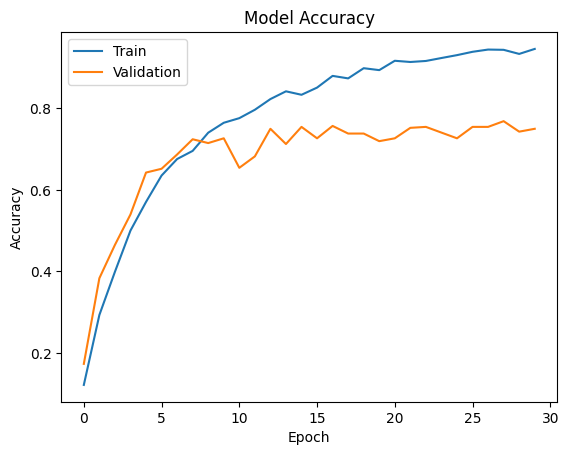

In [ ]:
# Plot the accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

It really stopped getting better at just under 10 epochs. Probably should have stopped the epochs then.


In [ ]:
accuracy = model1.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', accuracy)

15/15 - 0s - 6ms/step - accuracy: 0.7495 - loss: 1.1446
Test accuracy: [1.1445631980895996, 0.7494736909866333]


In [ ]:
# Getting the output as probabilities for each category
y_pred = model1.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


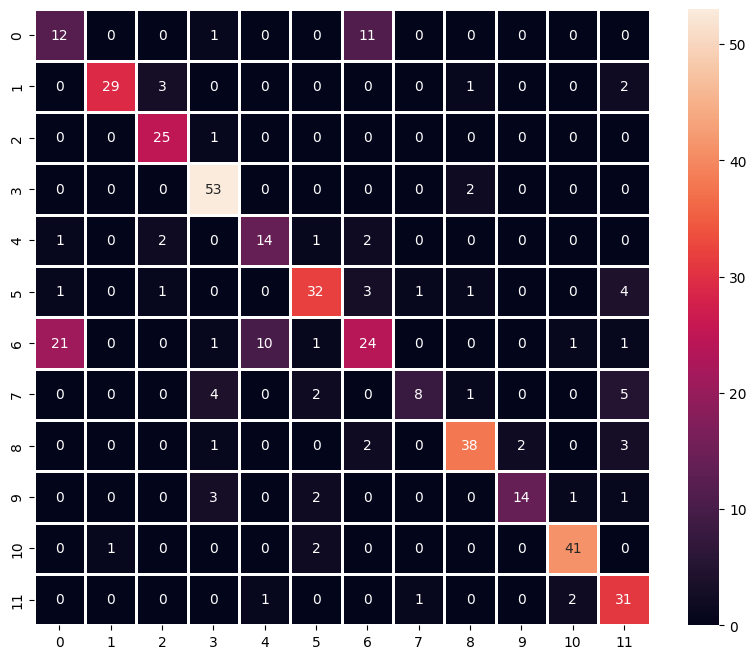

In [ ]:
# Getting predictions on the validation set
y_pred_val = model1.predict(X_val)
y_pred_val_arg = np.argmax(y_pred_val, axis=1)

# Plotting the confusion matrix using confusion matrix function from tensorflow
confusion_matrix = tf.math.confusion_matrix(y_val_arg, y_pred_val_arg)  # Changed to use validation set predictions
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, linewidths=True, fmt='d', square=True)  # Removed ax=ax
plt.show()

## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

Our model does quite well identifying most of the plants. However, it is quite bad and identifying the plants in label 0 (at about 50% accuracy) and label 6 (at less than 50% accuracy).

### Visualizing the prediction

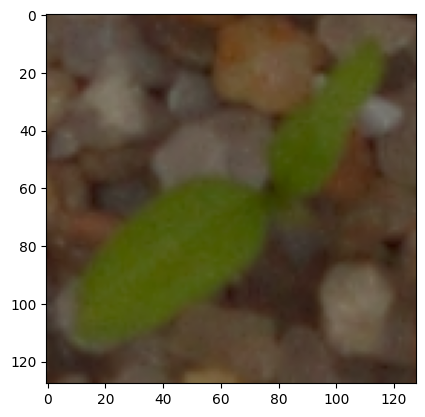

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label [3]
True label [9]


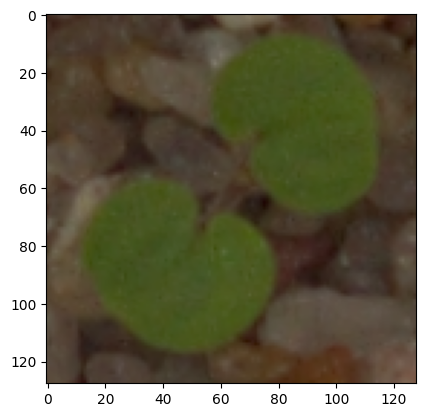

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label [10]
True label [8]


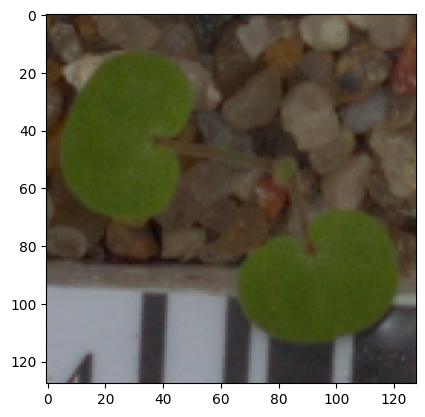

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label [10]
True label [3]


In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Convert y_train to 1D array if it's one-hot encoded
y_train_1d = np.argmax(y_train, axis=1)

enc = LabelEncoder()
enc.fit(y_train_1d)

# Visualizing the predicted and correct label of images from test data
plt.imshow(X_test[0])
plt.show()
print("Predicted label", enc.inverse_transform(model1.predict(X_test[0].reshape(1, 128, 128, 3)).argmax(axis=1)))
print("True label", enc.inverse_transform([y_train_1d[0]]))

plt.imshow(X_test[1])
plt.show()
print("Predicted label", enc.inverse_transform(model1.predict(X_test[1].reshape(1, 128, 128, 3)).argmax(axis=1)))
print("True label", enc.inverse_transform([y_train_1d[1]]))

plt.imshow(X_test[3])
plt.show()
print("Predicted label", enc.inverse_transform(model1.predict(X_test[3].reshape(1, 128, 128, 3)).argmax(axis=1)))
print("True label", enc.inverse_transform([y_train_1d[36]]))

## Actionable Insights and Business Recommendations

It's interesting that our final model was just a convolutional neural network without a lot of layers or data augmentation. Transfer learning models didn't help, either.  

Given more time and resources, we should check whether unfreezing some of the back-end convolutional layers and training them would help improve the model. I would also like to try the SGD optimization to see if either of those changes improves the Transfer Learning models. We could also try the 3rd and newest Transfer Learning model and see if that does better.

* The company should consider training additional models to try to improve the accuracy further.
* The company should consider using SGD Optimizer with the Transfer Learning models to see if accuracy improves.
* The company should consider using Efficient Net to see if it does better.
* With the Transfer Learning models, the company should consider unfreezing some of the last convolutional layers and try training those to see if it improves model performance.
* The company should consider looking at its data inputs for classes 0 and 6. If the data quality can be improved for those images, the models might do better and accuracy could further improve.

_____